# IV. Zonal statistics, spectral signatures and vegetation index

---
**Author(s):** Kenji Ose, Quentin Yeche, Dino Ienco - [UMR TETIS](https://umr-tetis.fr) / [INRAE](https://www.inrae.fr/)

---

## 1. Introduction

Here are presented two solutions for computing zonal statistics on Sentinel-2 image with polygon vector file. We will try two librairies : `xrspatial` and `rasterstats`.

### 1.1. Outline

In [section 4](#4-loading-the-polygon-vector-file) we will be loading vector data from a file and converting it to a raster so that we can use it to delimit zones

In [section 5](#5-computing-of-zonal-statistics) we will be computing zonal statistics using two different methods, and getting the results back in the form of an xarray Dataset.

In [section 6](#6-spectral-signatures) we will plot spectral signatures.

Finally [section 7](#7-band-math-and-vegetation-index) will cover calculating and display indexes such as the NDVI.

## 2. Library imports

As usual, we import all the required Python libraries. The two new ones in this notebook are `xrspatial` and `rasterstats` which are two libraries for computing zonal statistics. 

In [ ]:
# this cell is only useful if you're using an environment like Google Collab or
# Microsoft Planetary Computer's servers
def test_import_or_install(imports):
  import importlib
  restart_needed = False
  for import_name, pip_name in imports:
    try:
      importlib.import_module(import_name, package=None)
    except ModuleNotFoundError:
      if not restart_needed:
          restart_needed= True
          print('\033[91m' + ("ONE OR MORE LIBRARIES HAVE TO BE INSTALLED, "
          "PLEASE RESTART THE NOTEBOOK AFTER THIS CELL FINISHES EXECUTING "
          "TO ENSURE PROPER FUNCTIONALITY") + "\x1b[0m")
      %pip install {pip_name}
  if restart_needed:
    print('\033[91m' + ("LIBRARIES HAVE BEEN INSTALLED. "
          "PLEASE RESTART THE NOTEBOOK NOW ") + "\x1b[0m")

imports = [('pystac_client', 'pystac-client'),
           ('planetary_computer', 'planetary-computer'),
           ('stackstac', 'stackstac'),
           ('xrspatial', 'xarray-spatial'),
           ('rasterstats', 'rasterstats')
           ]

test_import_or_install(imports)

In [1]:
# STAC access
import pystac_client
import planetary_computer

# (geo)dataframes
import pandas as pd
import geopandas as gpd

# xarrays
import xarray as xr

from rasterio import features

# library for turning STAC objects into xarrays
import stackstac

# visualization
from matplotlib import pyplot as plt

# libraries for zonal stats
import xrspatial
import rasterstats

# miscellanous
import numpy as np
from IPython.display import display

## 3. Creating a `DataArray` from STAC object

### 3.1. Getting a Sentinel-2 STAC Item 

As a practical use case let's consider that we have identified the STAC Item we're interested in (see [this notebook](Joensuu_01-STAC.ipynb) for a refresher), and we also have an area of interest defined as a bounding box.

In [2]:
# Access to Planetary Computer API
root_catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

item_id = 'S2A_MSIL2A_20201213T104441_R008_T31TEJ_20201214T083443'
stac_item = root_catalog.get_collection("sentinel-2-l2a").get_item(item_id)

### 3.2. Loading the Sentinel-2 image

We stack the item's assets, which are the spectral bands, into a `DataArray` with a resampling at a spatial resolution of 10m.

We also collect metadata that will be useful for the following processing steps.

In [3]:
# bounding box expressed in Lat/Lon
aoi_bounds = (3.875107329166124, 43.48641456618909, 4.118824575734205, 43.71739887308995)

# bands of interest
bands_of_interest = ['B02','B03','B04','B05','B06','B07','B08','B11','B12']

FILL_VALUE = 2**16-1

ds = stackstac.stack(
                stac_item,
                assets = bands_of_interest,
                resolution=10,
                dtype="uint16",
                fill_value=FILL_VALUE,
                bounds_latlon=aoi_bounds,
                    ).squeeze()

s2_ref_crs = ds.crs
s2_ref_trf = ds.transform
s2_ref_shape = (ds['y'].size, ds['x'].size)

print(f'- S2 CRS: {s2_ref_crs}')
print(f'- S2 affine transform: \n{s2_ref_trf}')
print(f'- S2 YX dimension: {s2_ref_shape}')

- S2 CRS: epsg:32631
- S2 affine transform: 
| 10.00, 0.00, 570490.00|
| 0.00,-10.00, 4841100.00|
| 0.00, 0.00, 1.00|
- S2 YX dimension: (2590, 1999)


/home/quentin/miniconda3/envs/beyond/lib/python3.11/site-packages/stackstac/prepare.py:364: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


## 4. Loading the polygon vector file

### 4.1. Conversion into data array

The vector file, named `sample.geojson`, contains vector data defining 13 rectangular zones which will be our area of interest. The file has an attribute table with the following information:
- **fid**: unique ID [integer]
- **geometry**: coordinates of entity's polygon <[list]
- **landcover**: label [string]

In [4]:
zones_df = gpd.read_file('sample.geojson')
print(f"GeoDataFrame uses {zones_df.crs}")
zones_df

GeoDataFrame uses EPSG:4326


,fid,landcover,geometry
0,1,urban01,"POLYGON ((3.91165 43.57305, 3.91165 43.57490, ..."
1,2,urban02,"POLYGON ((3.93971 43.57152, 3.93971 43.57383, ..."
2,3,urban03,"POLYGON ((3.87511 43.60920, 3.87511 43.61179, ..."
3,4,baresoil01,"POLYGON ((3.93528 43.62391, 3.93528 43.62714, ..."
4,5,baresoil02,"POLYGON ((3.98472 43.64148, 3.98472 43.64420, ..."
5,6,agri01,"POLYGON ((4.04561 43.62706, 4.04561 43.62959, ..."
6,7,agri02,"POLYGON ((4.10558 43.65974, 4.10558 43.66209, ..."
7,8,agri03,"POLYGON ((4.11217 43.59764, 4.11217 43.60231, ..."
8,9,water01,"POLYGON ((4.01531 43.56791, 4.01531 43.58062, ..."
9,10,water02,"POLYGON ((3.98148 43.48641, 3.98148 43.52013, ..."


The GeoDataFrame uses the CRS EPSG:4326. However we previously saw that our Sentinel-2 data has EPSG:32631 for its CRS. We need to reproject one of them to match the other's CRS. It is almost always recommended to reproject vector data rather than raster data. Since vector data is essentially continuous reprojecting is seamless. On the other hand raster data is discrete (pixels) so a reprojection typically entails interpolating new pixel values which is undesirable.

Conveniently `geopandas` includes a `to_crs` method to reproject a GeoDataFrame to a new CRS.

In [5]:
zones_df = zones_df.to_crs(s2_ref_crs)
zones_df.crs

<Projected CRS: EPSG:32631>
Name: WGS 84 / UTM zone 31N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 0°E and 6°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Andorra. Belgium. Benin. Burkina Faso. Denmark - North Sea. France. Germany - North Sea. Ghana. Luxembourg. Mali. Netherlands. Niger. Nigeria. Norway. Spain. Togo. United Kingdom (UK) - North Sea.
- bounds: (0.0, 0.0, 6.0, 84.0)
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In order to compute zonal statistics, first we have to convert the vector zone data into a labeled raster with `rasterio.features`. Labels must be of integer type.

In [6]:
geometry = zones_df[['geometry', 'fid']].values.tolist()

# creating a raster from the vector data, which an overall shape identical to ds
# and using the same transform as ds
zones_mask = features.rasterize(geometry, out_shape=s2_ref_shape, fill=0, transform=s2_ref_trf)
# converting the numpy array in a DataArray so the types are the same
zones_mask= xr.DataArray(zones_mask, dims=ds.isel(band=0).dims)
zones_mask

<xarray.DataArray (y: 2590, x: 1999)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Dimensions without coordinates: y, x

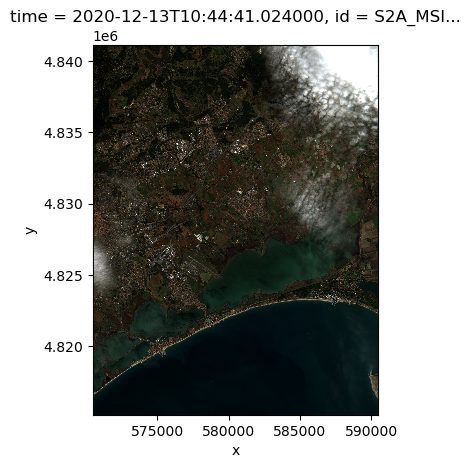

In [7]:
ds.sel(band=['B04', 'B03', 'B02']).plot.imshow(robust=True)
plt.gca().set_aspect('equal')
plt.show()

### 4.2. Displaying the labeled image

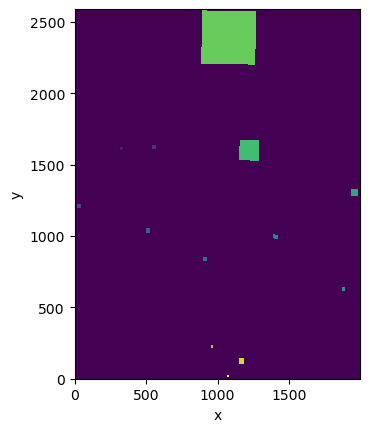

In [8]:
zones_mask.plot.imshow(add_colorbar=False)
plt.gca().set_aspect('equal')
plt.show()

## 5. Computing of zonal statistics 

### 5.1. Solution 1: with `xrspatial`

Here, we compute statistics based on each Sentinel-2 bands and merge the results into the vector file attribute table.

We will use the `zonal_stats` function of `xrspatial`. However this function only handles one band at a time. So we create a function, named `s2_zonal_stats`, that calls `xrspatial.zonal_stats` once for each band and aggregates the results into an xarray Dataset.

In [9]:
def s2_zonal_stats(ds, zones_mask, zones_df, pre_compute = True):
    # compute is needed at some point because
    # both ds and patch_mask must be numpy backed DataArrays.
    # It is faster to pre-compute all bands at once
    # but requires more memory
    if pre_compute:
        ds = ds.compute()
    final = zones_df.copy()
    band_xarrays = []
    for band_name, single_band in ds.groupby('band'):
        # will do nothing if pre_compute = True
        # otherwise will turn single_band into a numpy backed DataArray
        single_band = single_band.compute()
        sign_spectral = xrspatial.zonal_stats(zones_mask, 
                                 single_band, 
                                 stats_funcs = ['count','min','mean','max'], nodata_values = 0)
        
        # merging the zonal stats with the zone id fid
        # using how='right' because we want to discard any zone which isn'try
        # in zones_df (in this case it's the rest of the images which zonal_stats considers
        # its own zone)
        sign_spectral = sign_spectral.merge(zones_df['fid'], 
                                            how='right',
                                            left_on='zone', 
                                            right_on='fid')
                                            
        sign_spectral = sign_spectral.drop('zone', axis=1).set_index('fid', drop=True)
        band_xarrays.append(sign_spectral.to_xarray())
    

    final = xr.concat(band_xarrays, 'band')
    final = final.assign_coords({'band': ('band', ds.band.data),
                                 'landcover':('fid', zones_df['landcover'])
                                 })

        
    return final

In [10]:
stats = s2_zonal_stats(ds, zones_mask, zones_df)
stats

<xarray.Dataset>
Dimensions:    (fid: 13, band: 9)
Coordinates:
  * fid        (fid) int64 1 2 3 4 5 6 7 8 9 10 11 12 13
  * band       (band) <U3 'B02' 'B03' 'B04' 'B05' 'B06' 'B07' 'B08' 'B11' 'B12'
    landcover  (fid) object 'urban01' 'urban02' ... 'forest02' 'forest03'
Data variables:
    count      (band, fid) float64 531.0 693.0 928.0 ... 294.0 1.435e+03 195.0
    min        (band, fid) float64 133.0 277.0 70.0 77.0 ... 400.0 233.0 626.0
    mean       (band, fid) float64 704.0 1.803e+03 650.6 ... 358.1 1.131e+03
    max        (band, fid) float64 1.64e+03 3.57e+03 ... 527.0 1.571e+03

### 5.2 Solution 2: with `rasterstats`

The main difference of `rasterstats`'s version of `zonal_stats` is that it can be used on a STAC Item with vector data directly. The `ds` and `zones_mask` DataArrays are absolutely unneeded. In this case as well it calculates stats on one band again. Similarly to before, let's create a function, named `s2_zonal_stats2` which calls `rasterstats.zonal_stats` for each band.

In [11]:
def s2_zonal_stats2(stac_item, band_names, zones_df):
    fids = zones_df['fid']
    band_xarrays = []
    for band_name in band_names:
        zs = rasterstats.zonal_stats(zones_df, stac_item.assets[band_name].href, stats="count min mean max median")
        sign_spectral = pd.concat([fids, pd.DataFrame(zs)], axis=1).set_index('fid', drop=True)
        band_xarrays.append(sign_spectral.to_xarray())
        
    final = xr.concat(band_xarrays, 'band')
    final = final.assign_coords({'band': ('band', band_names),
                                 'landcover':('fid', zones_df['landcover'])
                                 })

    return final

In [12]:
stats2 = s2_zonal_stats2(stac_item, bands_of_interest, zones_df)
stats2

/home/quentin/miniconda3/envs/beyond/lib/python3.11/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


<xarray.Dataset>
Dimensions:    (fid: 13, band: 9)
Coordinates:
  * fid        (fid) int64 1 2 3 4 5 6 7 8 9 10 11 12 13
  * band       (band) <U3 'B02' 'B03' 'B04' 'B05' 'B06' 'B07' 'B08' 'B11' 'B12'
    landcover  (fid) object 'urban01' 'urban02' ... 'forest02' 'forest03'
Data variables:
    min        (band, fid) float64 133.0 277.0 70.0 77.0 ... 400.0 233.0 626.0
    max        (band, fid) float64 1.64e+03 3.57e+03 ... 527.0 1.571e+03
    mean       (band, fid) float64 704.0 1.803e+03 650.6 ... 357.1 1.118e+03
    count      (band, fid) int64 531 693 928 1097 874 ... 4779 35318 72 347 49
    median     (band, fid) float64 674.0 1.676e+03 645.5 ... 356.0 1.141e+03

### 5.3. Storing the results in a xarray Dataset

The result returned by both versions of s2_zonal_stats may look like a DataArray but it is in fact an xarray Dataset. A Dataset is simply a collection of different DataArrays (or variables) which share the same coordinates and dimensions. 

In our case all of our different statistics (mean, count, median, etc.) share the same dimensions: band and fid (zone identifier), so they exist as different variables of the same Dataset.


It is very easy to select an individual variable and obtain the habitual DataArray

In [13]:
# In this case the .count syntax would not work
# since count() is a built-in method of xarray.Dataset.
# In fact all of our current variable names happen to share their
# name with a method, so only the bracket syntax will work
stats['count']

<xarray.DataArray 'count' (band: 9, fid: 13)>
array([[   531.,    693.,    928.,   1097.,    874.,    987.,    570.,
          2786.,  19109., 141260.,    294.,   1435.,    195.],
       [   531.,    693.,    928.,   1097.,    874.,    987.,    570.,
          2786.,  19109., 141260.,    294.,   1435.,    195.],
       [   531.,    693.,    928.,   1097.,    874.,    987.,    570.,
          2786.,  19109., 141260.,    294.,   1435.,    195.],
       [   531.,    693.,    928.,   1097.,    874.,    987.,    570.,
          2786.,  19109., 141260.,    294.,   1435.,    195.],
       [   531.,    693.,    928.,   1097.,    874.,    987.,    570.,
          2786.,  19109., 141260.,    294.,   1435.,    195.],
       [   531.,    693.,    928.,   1097.,    874.,    987.,    570.,
          2786.,  19109., 141260.,    294.,   1435.,    195.],
       [   531.,    693.,    928.,   1097.,    874.,    987.,    570.,
          2786.,  19109., 141260.,    294.,   1435.,    195.],
       [   531.,    693.,    928.,   1097.,    874.,    987.,    570.,
          2786.,  19109., 141260.,    294.,   1435.,    195.],
       [   531.,    693.,    928.,   1097.,    874.,    987.,    570.,
          2786.,  19109., 141260.,    294.,   1435.,    195.]])
Coordinates:
  * fid        (fid) int64 1 2 3 4 5 6 7 8 9 10 11 12 13
  * band       (band) <U3 'B02' 'B03' 'B04' 'B05' 'B06' 'B07' 'B08' 'B11' 'B12'
    landcover  (fid) object 'urban01' 'urban02' ... 'forest02' 'forest03'

## 6. Spectral signatures

Now we have the summary statistics for several landcover types, we can plot their spectral signatures.

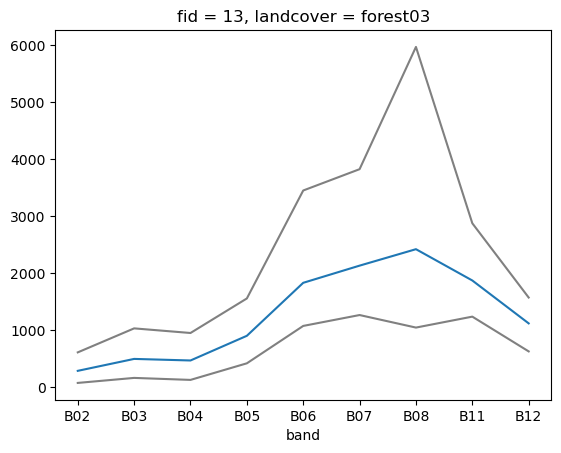

In [14]:
stats2.sel(fid=(stats2.landcover=='forest03'))['mean'].plot()
stats2.sel(fid=(stats2.landcover=='forest03'))['max'].plot(c='gray')
stats2.sel(fid=(stats2.landcover=='forest03'))['min'].plot(c='gray')
# turning off the y axis label since it would wrongly say 'min' otherwise
plt.ylabel(None)
plt.show()


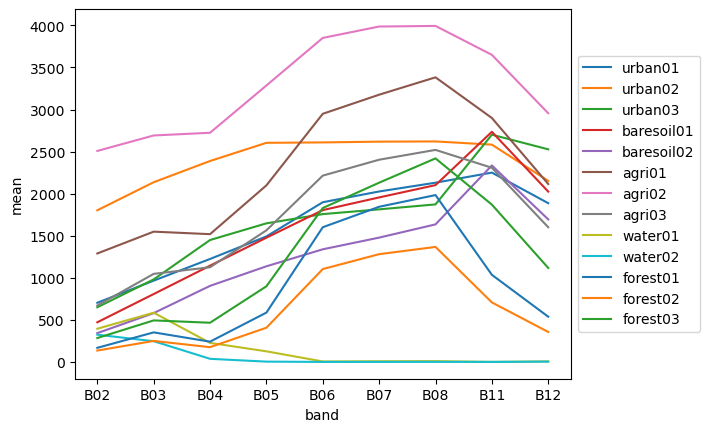

In [15]:
# the parameter hue='fid' means that each
# value in the 'fid' dimension leads to a different line
# which means one coloured line per zone
stats2['mean'].plot.line(hue='fid')
plt.legend(stats2.landcover.values, loc='center left', bbox_to_anchor=(1, 0.5))

## 7. Band math and vegetation index 

### 7.1. NDVI principles

The NDVI (Normalized Difference Vegetation Index) is a vegetation index based on the difference between red and near infrared (nIR) values. Its formula is as follows:

$$NDVI = {nIR - Red \over nIR + Red}$$

This index exploits the spectral signature of the vegetation which is very particular, because it shows a very marked peak in the near infrared, and a lower reflectance in the red. This index is very effective in determining the presence of vegetation, but it can also be used to to evaluate the importance of the vegetation biomass as well as the intensity of the photosynthesis activity.

In [16]:
nir, red = ds.sel(band="B08").astype('float'), ds.sel(band="B04").astype('float')
ndvi = (nir-red)/(nir+red)
ndvi.name='NDVI'

### 7.2. Plotting the NDVI

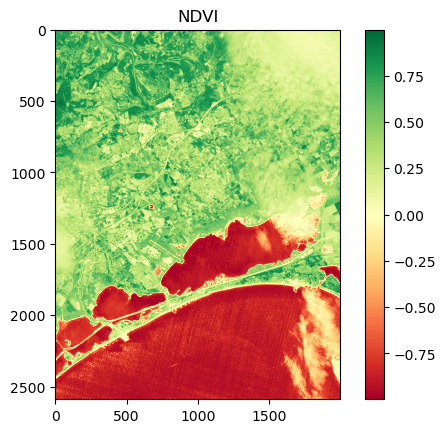

In [17]:
plt.imshow(ndvi.squeeze(), cmap="RdYlGn")
plt.colorbar()
plt.title('NDVI')
plt.show()

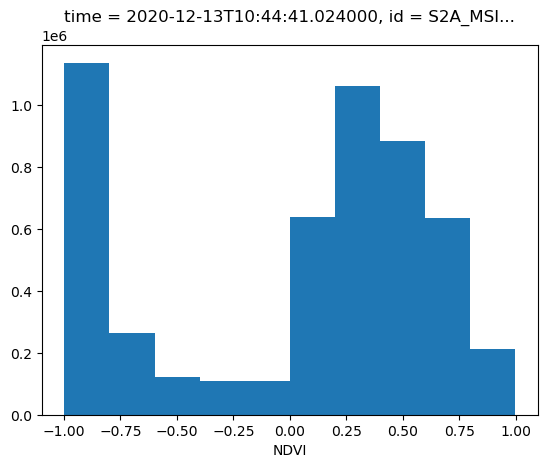

In [18]:
ndvi.plot.hist()
plt.show()

### 7.3. Using Jupyter widgets

It is possible to add elements (*slider*, *progress bar*, *checkbox*, *radio buttons*, etc.) to interact with the data visualization. To do this, load the `ipywidgets` library.

In [19]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

def threshold(seuil):
    seuil = np.where(ndvi.squeeze()>seuil, 1, 0)
    plt.imshow(seuil, cmap="viridis", interpolation='nearest')#, cmap=plt.cm.gray)
    plt.colorbar()
    plt.show()

interact(threshold, seuil = widgets.FloatSlider(min=-1, max=1, step=0.001))

interactive(children=(FloatSlider(value=0.0, description='seuil', max=1.0, min=-1.0, step=0.001), Output()), _…

<function __main__.threshold(seuil)>